In [2]:
import os
import sys
import pandas as pd
import numpy as np
import requests
import math
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
import ast
import re
#from dataprep.clean import clean_address
import seaborn as sns
from datetime import datetime, date
from sklearn import metrics, ensemble, preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, brier_score_loss,  f1_score, log_loss,
                             precision_score, recall_score,roc_auc_score, accuracy_score,confusion_matrix, 
                             classification_report,cohen_kappa_score, make_scorer)
from sklearn.feature_selection import mutual_info_classif   
from scipy import stats
from sklearn import calibration
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import folium #for muti-maps
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
%matplotlib inline
from lazypredict.Supervised import LazyClassifier

import random
import time
import censusgeocode as cg  #MODEL_CONFIG
import censusdata
import csv


pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
def unique (df):
    dfun = df.nunique(axis=0)
    dfun_df = pd.DataFrame(dfun) 
    column_names=["Distinct"]
    dfun_df.columns = column_names
    dfun_df_sorted = dfun_df.sort_values('Distinct', ascending=False)
    return (dfun_df_sorted)

def check_missing_values (df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    if missing_value_df['percent_missing'].any():
        return missing_value_df
    else: 
        return "No missing values"


def not_yet_joined (df1, joined_df, variabe_df1):  
    need_to_join= df1[~df1[variabe_df1].isin(joined_df[variabe_df1])]
    #need_to_join.reset_index(drop=True, inplace=True)
    return need_to_join

 
filepath = "/Users/margaretcatherman"
epsg = "4326"  #EPSG correct


# Feature selection with several criterium. For trainin data ony.

    Rule of Thumb for Interpreting Correlation Coefficients:

    Size of Correlation	Interpretation
    .90 to 1.00 (−.90 to −1.00)	Very high positive (negative) correlation
    .70 to .90 (−.70 to −.90)	High positive (negative) correlation
    .50 to .70 (−.50 to −.70)	Moderate positive (negative) correlation
    .30 to .50 (−.30 to −.50)	Low positive (negative) correlation
    .00 to .30 (.00 to −.30)	negligible correlation

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/


Correlation coefficients whose magnitude are between 0.9 and 1.0 indicate variables which can be considered very highly correlated. Correlation coefficients whose magnitude are between 0.7 and 0.9 indicate variables which can be considered highly correlated. Correlation coefficients whose magnitude are between 0.5 and 0.7 indicate variables which can be considered moderately correlated. Correlation coefficients whose magnitude are between 0.3 and 0.5 indicate variables which have a low correlation. Correlation coefficients whose magnitude are less than 0.3 have little if any (linear) correlation. 
https://www.andrews.edu/~calkins/math/edrm611/edrm05.htm

In [50]:
def spearman_collinearity_processor (df):
    df2 = df.copy()
    df3 = df2.drop(['FireIndicator'],axis=1)
    cor_matrix = df3.corr(method = 'spearman').abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.75)]
    df2.drop(df2[to_drop], axis=1, inplace=True) 
    return df2

#from scipy import stats
#from sklearn.feature_selection import mutual_info_classif            
def feature_selection_processor (training_data, threshold):
    '''
    Feature selection with several criterium:
    
    A) First, omit features  w/ pointbiserialr correlation > 75 w/ 
    dependent variable.  Pointbiserialr Correlation is used because the independent variables are continuous 
    & the dependent variable is binomial. 
    
    B) Next, use Mutual information for classification to identify independent 
    variables of importance to the dependents variable. Note: This metric does not have omission thresholds, 
    unlike correlation matrices. Threshold: > .20.  
    
    C) Collinearity identification and removal among independent variables. 
    Variables with spearman's correlation > .75 will be removed.
    '''
    td = training_data.copy()
    #Prepare data:  remove irrelevent variables, ie  geometry:
    cols = ['District','Call_Cat_100_fi_mean', 'Call_Cat_100_fi_sum', 'BG_ID', 'Districts', 
            'BG_ID_6', 'geometry_6_tg', 'geometry_9_tg','centerpoint_ad', 'geometry',
            'geometry_6_tg', 'x_sh_mean','y_sh_mean','x_sh_sum', 'y_sh_sum', 'latitude_ad', 'longitude_ad']
    jdfr = td.loc[:, ~td.columns.isin(cols)]
    df = jdfr.apply(pd.to_numeric, errors='coerce')
    
    corr_list = []
    y = df['FireIndicator'].astype(float)
    #A. Cec corr w/ dependent variabe, via pointbiserialr for corr of Continuous Xs w/ binomia as y
    for column in df:
        x=df[column]
        corr = stats.pointbiserialr(list(x), list(y)) #pointbiserialr for corr of Continuous Xs w/ binomia as y
        corr_list.append(corr[0])
    corrdf = df.corr()
    cmmf = corrdf.loc["FireIndicator"]  #from cor_matrix
    cmmfdf = cmmf.to_frame()
    cmmfdft = cmmfdf.T
    cmmfdft2 = cmmfdft.dropna(axis=1, how='all')
    pointbiserialr =  cmmfdft2.T
    pointbiserialr.sort_values(['FireIndicator'],ascending=False, inplace = True)
    #remove predictors w/ correlation >.85 w/ dependent variabe
    drop_cols = [column for column in cmmfdft2.columns if any(cmmfdft2[column] > .75)]  #.between(0.30, 0.85))]
    keep = {'FireIndicator','BG_ID_6'}
    drop_cols = [e for e in drop_cols if e not in keep]
    jdfr_2 = df.loc[:, ~df.columns.isin(drop_cols)]
    
    # B. Mutual_info_classif to identify important features
    X = jdfr_2.drop(['FireIndicator'],axis=1)
    y = jdfr_2[['FireIndicator']] #target 
    mir = mutual_info_classif(X, y)
    mir_max=mir.copy()
    mir_max /= np.max(mir_max)
    mis = pd.Series(mir_max)
    mis.index = X.columns
    mis.sort_values(ascending=False, inplace = True)
    misdf_raw = mis.to_frame()
    misdf_raw.columns =['FireIndicator']  #, 'Code', 'Age', 'Weight']
    misdf = misdf_raw.loc[(misdf_raw['FireIndicator'] >= threshold)]# SF & (misdf['FireIndicator'] <= .95)]
    indx_lst = misdf.index.values.tolist()  # an ndarray method, you probably shouldn't depend on this
    b = ['FireIndicator', 'BG_ID_6']
    indx_lst += b
    jdfr_3 = jdfr_2.loc[:, jdfr_2.columns.isin(indx_lst)]    
    
    #C) Collinearity identification and removal
    train_sel = spearman_collinearity_processor (jdfr_3)
    return train_sel, misdf, pointbiserialr

#Optiona, to view matrix
def show_spearman_sans_dependent (df):
    df2 = df.drop(['FireIndicator'],axis=1) 
    corr_df = df2.corr(method = 'spearman')
    return corr_df.style.background_gradient(cmap='coolwarm')    


# Part 2: The Model & Fire Risk Prediction Table
# A. Single Family

joined_df_raw_mf.to_csv('joined_df_raw_mf_2.csv', na_rep='NA' )
joined_df_raw_sf.to_csv('joined_df_raw_sf_2.csv', na_rep='NA' )


In [56]:
#joined_df_raw_mf.to_csv('joined_df_raw_mf_2.csv', na_rep='NA' )

joined_df_raw_sf = pd.read_csv('joined_df_raw_sf_2.csv')
joined_df_raw_sf=joined_df_raw_sf.astype({'BG_ID_9_tg':str})
joined_df_raw_sf.set_index(['BG_ID_9_tg'], inplace = True)   #set_index('Address_tp')
joined_df_raw_sf.info()
joined_df_raw_sf.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 3392 entries, 211011004 to 238034002
Columns: 934 entries, BG_ID_6 to y_sh_sum
dtypes: float64(62), int64(870), object(2)
memory usage: 24.2+ MB


,BG_ID_6,Estimate!!Total!!Owner-occupied housing units,"Estimate!!Total!!Owner-occupied housing units!!1, detached","Estimate!!Total!!Owner-occupied housing units!!1, attached",Estimate!!Total!!Owner-occupied housing units!!2,Estimate!!Total!!Owner-occupied housing units!!3 or 4,Estimate!!Total!!Owner-occupied housing units!!5 to 9,Estimate!!Total!!Owner-occupied housing units!!10 to 19,Estimate!!Total!!Owner-occupied housing units!!20 to 49,Estimate!!Total!!Owner-occupied housing units!!50 or more,Estimate!!Total!!Owner-occupied housing units!!Mobile home,"Estimate!!Total!!Owner-occupied housing units!!Boat, RV, van, etc.",Estimate!!Total!!Renter-occupied housing units,"Estimate!!Total!!Renter-occupied housing units!!1, detached","Estimate!!Total!!Renter-occupied housing units!!1, attached",Estimate!!Total!!Renter-occupied housing units!!2,Estimate!!Total!!Renter-occupied housing units!!3 or 4,Estimate!!Total!!Renter-occupied housing units!!5 to 9,Estimate!!Total!!Renter-occupied housing units!!10 to 19,Estimate!!Total!!Renter-occupied housing units!!20 to 49,Estimate!!Total!!Renter-occupied housing units!!50 or more,Estimate!!Total!!Renter-occupied housing units!!Mobile home,"Estimate!!Total!!Renter-occupied housing units!!Boat, RV, van, etc.","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Second mortgage only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Home equity loan only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!Both second mortgage and home equity loan","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!No second mortgage and no home equity loan",Estimate!!Total!!Housing units without a mortgage,Estimate!!Total!!Housing units with a mortgage,Estimate!!Total!!Housing units with a mortgage!!Less than $200,Estimate!!Total!!Housing units with a mortgage!!$200 to $299,Estimate!!Total!!Housing units with a mortgage!!$300 to $399,Estimate!!Total!!Housing units with a mortgage!!$400 to $499,Estimate!!Total!!Housing units with a mortgage!!$500 to $599,Estimate!!Total!!Housing units with a mortgage!!$600 to $699,Estimate!!Total!!Housing units with a mortgage!!$700 to $799,Estimate!!Total!!Housing units with a mortgage!!$800 to $899,Estimate!!Total!!Housing units with a mortgage!!$900 to $999,"Estimate!!Total!!Housing units with a mortgage!!$1,000 to $1,249","Estimate!!Total!!Housing units with a mortgage!!$1,250 to $1,499","Estimate!!Total!!Housing units with a mortgage!!$1,500 to $1,999","Estimate!!Total!!Housing units with a mortgage!!$2,000 to $2,499","Estimate!!Total!!Housing units with a mortgage!!$2,500 to $2,999","Estimate!!Total!!Housing units with a mortgage!!$3,000 to $3,499","Estimate!!Total!!Housing units with a mortgage!!$3,500 to $3,999","Estimate!!Total!!Housing units with a mortgage!!$4,000 or more",Estimate!!Total!!Housing units without a mortgage!!Less than $100,Estimate!!Total!!Housing units without a mortgage!!$100 to $149,Estimate!!Total!!Housing units without a mortgage!!$150 to $199,Estimate!!Total!!Housing units without a mortgage!!$200 to $249,Estimate!!Total!!Housing units without a mortgage!!$250 to $299,Estimate!!Total!!Housing units without a mortgage!!$300 to $349,Estimate!!Total!!Housing units without a mortgage!!$350 to $399,Estimate!!Total!!Housing units without a mortgage!!$400 to $499,Estimate!!Total!!Housing units without a mortgage!!$500 to $599,Estimate!!Total!!Housing units without a mortgage!!$600 to $699,Estimate!!Total!!Housing units without a mortgage!!$700

In [59]:
#joined_df = joined_df_sf.copy() #(3392, 13)
joined_df = joined_df_raw_sf.copy()
joined_df.shape  #4911, 189  (4925, 175)

(3392, 934)

In [60]:
joined_df.head(1)

,BG_ID_6,Estimate!!Total!!Owner-occupied housing units,"Estimate!!Total!!Owner-occupied housing units!!1, detached","Estimate!!Total!!Owner-occupied housing units!!1, attached",Estimate!!Total!!Owner-occupied housing units!!2,Estimate!!Total!!Owner-occupied housing units!!3 or 4,Estimate!!Total!!Owner-occupied housing units!!5 to 9,Estimate!!Total!!Owner-occupied housing units!!10 to 19,Estimate!!Total!!Owner-occupied housing units!!20 to 49,Estimate!!Total!!Owner-occupied housing units!!50 or more,Estimate!!Total!!Owner-occupied housing units!!Mobile home,"Estimate!!Total!!Owner-occupied housing units!!Boat, RV, van, etc.",Estimate!!Total!!Renter-occupied housing units,"Estimate!!Total!!Renter-occupied housing units!!1, detached","Estimate!!Total!!Renter-occupied housing units!!1, attached",Estimate!!Total!!Renter-occupied housing units!!2,Estimate!!Total!!Renter-occupied housing units!!3 or 4,Estimate!!Total!!Renter-occupied housing units!!5 to 9,Estimate!!Total!!Renter-occupied housing units!!10 to 19,Estimate!!Total!!Renter-occupied housing units!!20 to 49,Estimate!!Total!!Renter-occupied housing units!!50 or more,Estimate!!Total!!Renter-occupied housing units!!Mobile home,"Estimate!!Total!!Renter-occupied housing units!!Boat, RV, van, etc.","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Second mortgage only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Home equity loan only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!Both second mortgage and home equity loan","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!No second mortgage and no home equity loan",Estimate!!Total!!Housing units without a mortgage,Estimate!!Total!!Housing units with a mortgage,Estimate!!Total!!Housing units with a mortgage!!Less than $200,Estimate!!Total!!Housing units with a mortgage!!$200 to $299,Estimate!!Total!!Housing units with a mortgage!!$300 to $399,Estimate!!Total!!Housing units with a mortgage!!$400 to $499,Estimate!!Total!!Housing units with a mortgage!!$500 to $599,Estimate!!Total!!Housing units with a mortgage!!$600 to $699,Estimate!!Total!!Housing units with a mortgage!!$700 to $799,Estimate!!Total!!Housing units with a mortgage!!$800 to $899,Estimate!!Total!!Housing units with a mortgage!!$900 to $999,"Estimate!!Total!!Housing units with a mortgage!!$1,000 to $1,249","Estimate!!Total!!Housing units with a mortgage!!$1,250 to $1,499","Estimate!!Total!!Housing units with a mortgage!!$1,500 to $1,999","Estimate!!Total!!Housing units with a mortgage!!$2,000 to $2,499","Estimate!!Total!!Housing units with a mortgage!!$2,500 to $2,999","Estimate!!Total!!Housing units with a mortgage!!$3,000 to $3,499","Estimate!!Total!!Housing units with a mortgage!!$3,500 to $3,999","Estimate!!Total!!Housing units with a mortgage!!$4,000 or more",Estimate!!Total!!Housing units without a mortgage!!Less than $100,Estimate!!Total!!Housing units without a mortgage!!$100 to $149,Estimate!!Total!!Housing units without a mortgage!!$150 to $199,Estimate!!Total!!Housing units without a mortgage!!$200 to $249,Estimate!!Total!!Housing units without a mortgage!!$250 to $299,Estimate!!Total!!Housing units without a mortgage!!$300 to $349,Estimate!!Total!!Housing units without a mortgage!!$350 to $399,Estimate!!Total!!Housing units without a mortgage!!$400 to $499,Estimate!!Total!!Housing units without a mortgage!!$500 to $599,Estimate!!Total!!Housing units without a mortgage!!$600 to $699,Estimate!!Total!!Housing units without a mortgage!!$700

In [61]:
joined_df.FireIndicator.value_counts()

0    2084
1    1308
Name: FireIndicator, dtype: int64

In [62]:
# Train/Test 
y = np.array(joined_df['FireIndicator']) #(0,1) classification
X= joined_df.drop(columns=['FireIndicator'])   #,'Call_Cat_100_fi_sum', 'index_right_sum'], axis = 1)
#X= result_3m.drop(columns=['Unnamed: 0','FireIndicator','Call_Cat_100_fi_sum', 'index_right_sum'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)
#feature_list = list(X_train.columns)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (2544, 933)
Training Labels Shape: (2544,)
Testing Features Shape: (848, 933)
Testing Labels Shape: (848,)


In [63]:
#Put X_train & y_train back together for feature selection
train_sf= X_train.copy()
train_sf['FireIndicator'] = y_train.tolist()
train_sf.shape

(2544, 934)

In [64]:
train_sf.head(2)

,BG_ID_6,Estimate!!Total!!Owner-occupied housing units,"Estimate!!Total!!Owner-occupied housing units!!1, detached","Estimate!!Total!!Owner-occupied housing units!!1, attached",Estimate!!Total!!Owner-occupied housing units!!2,Estimate!!Total!!Owner-occupied housing units!!3 or 4,Estimate!!Total!!Owner-occupied housing units!!5 to 9,Estimate!!Total!!Owner-occupied housing units!!10 to 19,Estimate!!Total!!Owner-occupied housing units!!20 to 49,Estimate!!Total!!Owner-occupied housing units!!50 or more,Estimate!!Total!!Owner-occupied housing units!!Mobile home,"Estimate!!Total!!Owner-occupied housing units!!Boat, RV, van, etc.",Estimate!!Total!!Renter-occupied housing units,"Estimate!!Total!!Renter-occupied housing units!!1, detached","Estimate!!Total!!Renter-occupied housing units!!1, attached",Estimate!!Total!!Renter-occupied housing units!!2,Estimate!!Total!!Renter-occupied housing units!!3 or 4,Estimate!!Total!!Renter-occupied housing units!!5 to 9,Estimate!!Total!!Renter-occupied housing units!!10 to 19,Estimate!!Total!!Renter-occupied housing units!!20 to 49,Estimate!!Total!!Renter-occupied housing units!!50 or more,Estimate!!Total!!Renter-occupied housing units!!Mobile home,"Estimate!!Total!!Renter-occupied housing units!!Boat, RV, van, etc.","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Second mortgage only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Home equity loan only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!Both second mortgage and home equity loan","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!No second mortgage and no home equity loan",Estimate!!Total!!Housing units without a mortgage,Estimate!!Total!!Housing units with a mortgage,Estimate!!Total!!Housing units with a mortgage!!Less than $200,Estimate!!Total!!Housing units with a mortgage!!$200 to $299,Estimate!!Total!!Housing units with a mortgage!!$300 to $399,Estimate!!Total!!Housing units with a mortgage!!$400 to $499,Estimate!!Total!!Housing units with a mortgage!!$500 to $599,Estimate!!Total!!Housing units with a mortgage!!$600 to $699,Estimate!!Total!!Housing units with a mortgage!!$700 to $799,Estimate!!Total!!Housing units with a mortgage!!$800 to $899,Estimate!!Total!!Housing units with a mortgage!!$900 to $999,"Estimate!!Total!!Housing units with a mortgage!!$1,000 to $1,249","Estimate!!Total!!Housing units with a mortgage!!$1,250 to $1,499","Estimate!!Total!!Housing units with a mortgage!!$1,500 to $1,999","Estimate!!Total!!Housing units with a mortgage!!$2,000 to $2,499","Estimate!!Total!!Housing units with a mortgage!!$2,500 to $2,999","Estimate!!Total!!Housing units with a mortgage!!$3,000 to $3,499","Estimate!!Total!!Housing units with a mortgage!!$3,500 to $3,999","Estimate!!Total!!Housing units with a mortgage!!$4,000 or more",Estimate!!Total!!Housing units without a mortgage!!Less than $100,Estimate!!Total!!Housing units without a mortgage!!$100 to $149,Estimate!!Total!!Housing units without a mortgage!!$150 to $199,Estimate!!Total!!Housing units without a mortgage!!$200 to $249,Estimate!!Total!!Housing units without a mortgage!!$250 to $299,Estimate!!Total!!Housing units without a mortgage!!$300 to $349,Estimate!!Total!!Housing units without a mortgage!!$350 to $399,Estimate!!Total!!Housing units without a mortgage!!$400 to $499,Estimate!!Total!!Housing units without a mortgage!!$500 to $599,Estimate!!Total!!Housing units without a mortgage!!$600 to $699,Estimate!!Total!!Housing units without a mortgage!!$700

# Feature Selection on training data only, prior to SMOTE.
## X_test has Features reduced to match feature selection from analysis of training data; y_test is unchanged.

In [65]:
train_sel_sf, misdf_train_sf, pointbiserialr_train_sf = feature_selection_processor (train_sf, .20)
train_sel_sf.shape   #, joined_df_sf.shape (3392, 43))

(2544, 60)

In [66]:
misdf_train_sf

,FireIndicator
Call_Cat_300_fi_sum,1.00
POP20_tg,0.91
HOUSING20_tg,0.82
Call_Cat_600_fi_sum,0.66
Call_Cat_500_fi_sum,0.65
ALAND20_tg,0.64
Call_Cat_400_fi_sum,0.55
Call_Cat_700_fi_sum,0.50
class_sum_tp_sum,0.46
heat_mean_tp_sum,0.40


In [67]:
pointbiserialr_train_sf

,FireIndicator
FireIndicator,1.00
POP20_tg,0.36
HOUSING20_tg,0.36
Call_Cat_400_fi_sum,0.34
Call_Cat_300_fi_sum,0.33
Call_Cat_600_fi_sum,0.31
class_mean_tp_sum,0.31
heat_mean_tp_sum,0.31
class_sum_tp_sum,0.31
heat_sum_tp_sum,0.30


In [68]:
train_sel_sf.head(2)

,"Estimate!!Total!!Owner-occupied housing units!!1, detached",Estimate!!Median selected monthly owner costs (dollars)!!Housing units with a mortgage (dollars),Estimate!!Median selected monthly owner costs (dollars)!!Housing units without a mortgage (dollars),Estimate!!Total!!Population of one race,Estimate!!Total!!Population of one race!!White,Estimate!!Total!!Population of one race!!Asian alone,"Estimate!!Total!!Population of two or more races!!Two races excluding Some other race, and three or more races",Estimate!!Total!!Income in the past 12 months at or above poverty level!!Married-couple family,Estimate!!Total!!Income in the past 12 months at or above poverty level!!Married-couple family!!With related children of the householder under 18 years!!Under 5 years only,"Estimate!!Total!!Income in the past 12 months at or above poverty level!!Other family!!Female householder, no husband present!!No related children of the householder under 18 years",Estimate!!Total!!Income in the past 12 months at or above poverty level!!Family households!!Married-couple family!!Householder 25 to 44 years,"Estimate!!Total!!Income in the past 12 months at or above poverty level!!Family households!!Other family!!Female householder, no husband present!!Householder 25 to 44 years",Estimate!!Total!!Income in the past 12 months below poverty level!!In family households!!In married couple families!!All relatives,"Estimate!!Total!!Income in the past 12 months below poverty level!!In family households!!In other families!!Female householder, no husband present!!All relatives",Estimate!!Total!!Income in the past 12 months at or above poverty level!!In family households!!In other families,Estimate!!Total!!Income in the past 12 months at or above poverty level!!In non-family households and other living arrangement,Estimate!!Total!!Income in the past 12 months at or above poverty level!!In non-family households and other living arrangement!!Other living arrangement,Estimate!!Total!!Income in the past 12 months below poverty level!!No disability!!In labor force!!Civilian!!Employed,Estimate!!Total!!Income in the past 12 months at or above poverty level!!With a disability,Estimate!!Total!!Income in the past 12 months at or above poverty level!!No disability!!Not in labor force,Estimate!!Total!!18 to 64 years!!Nonveteran!!Income in the past 12 months below poverty level!!With a disability,Estimate!!Total!!18 to 34 years!!With one type of health insurance coverage,Estimate!!Total!!18 to 34 years!!No health insurance coverage,Estimate!!Total!!35 to 64 years!!With one type of health insurance coverage!!With direct-purchase health insurance only,Estimate!!Total!!35 to 64 years!!With two or more types of health insurance coverage!!Other coverage combinations,Estimate!!Total!!65 years and over!!With one type of health insurance coverage,Estimate!!Total!!Education,Estimate!!Total!!6 rooms,Estimate!!Total!!7 rooms,Estimate!!Total!!9 or more rooms,Estimate!!Total!!Renter occupied!!4 rooms,Estimate!!Total!!3 bedrooms,Estimate!!Total!!3 or more bedrooms,Estimate!!Total!!Different house in United States 1 year ago!!Same Micropolitan Statistical Area!!Moved from principal city,"Estimate!!Total!!With interest, dividends, or net rental income","Estimate!!Total!!No interest, dividends, or net rental income",Estimate!!Total!!Under 6 years!!Living with two parents,Estimate!!Total!!6 to 17 years!!Living with one parent,Estimate!!Total!!Renter occupied!!Built 2000 to 2009,Estimate!!Total!!Renter occupied!!1 or more vehicles available,Estimate!!Median gross rent,Estimate!!Total!!Different house,Estimate!!Total!!Owner occupied!!Built 2000 to 2009,Estimate!!Total!!Owner occupied!!Built 1990 to 1999,Estimate!!Total!!Owner occupied!!Moved in 1990 to 1999,Estimate!!Median household income in the past 12 months (in 2015 Inflation-adjusted dollars),Estimate!!Median household income in the past 12 months (in 2015 Inflation-adjusted dollars)!!Householder 25 to 44 years,Estimate!!Median select

In [69]:
#joined_df_raw_sf.head(2)

# Reassemble joined_df_sf & joined_df filtering w/ selected features from feature_selection_processor


In [70]:
features = list(train_sel_sf.columns)
joined_df_sf = joined_df_raw_sf.loc[:, joined_df_raw_sf.columns.isin(features)]
joined_df = joined_df_sf.copy()

joined_df.head(2)


,"Estimate!!Total!!Owner-occupied housing units!!1, detached",Estimate!!Median selected monthly owner costs (dollars)!!Housing units with a mortgage (dollars),Estimate!!Median selected monthly owner costs (dollars)!!Housing units without a mortgage (dollars),Estimate!!Total!!Population of one race,Estimate!!Total!!Population of one race!!White,Estimate!!Total!!Population of one race!!Asian alone,"Estimate!!Total!!Population of two or more races!!Two races excluding Some other race, and three or more races",Estimate!!Total!!Income in the past 12 months at or above poverty level!!Married-couple family,Estimate!!Total!!Income in the past 12 months at or above poverty level!!Married-couple family!!With related children of the householder under 18 years!!Under 5 years only,"Estimate!!Total!!Income in the past 12 months at or above poverty level!!Other family!!Female householder, no husband present!!No related children of the householder under 18 years",Estimate!!Total!!Income in the past 12 months at or above poverty level!!Family households!!Married-couple family!!Householder 25 to 44 years,"Estimate!!Total!!Income in the past 12 months at or above poverty level!!Family households!!Other family!!Female householder, no husband present!!Householder 25 to 44 years",Estimate!!Total!!Income in the past 12 months below poverty level!!In family households!!In married couple families!!All relatives,"Estimate!!Total!!Income in the past 12 months below poverty level!!In family households!!In other families!!Female householder, no husband present!!All relatives",Estimate!!Total!!Income in the past 12 months at or above poverty level!!In family households!!In other families,Estimate!!Total!!Income in the past 12 months at or above poverty level!!In non-family households and other living arrangement,Estimate!!Total!!Income in the past 12 months at or above poverty level!!In non-family households and other living arrangement!!Other living arrangement,Estimate!!Total!!Income in the past 12 months below poverty level!!No disability!!In labor force!!Civilian!!Employed,Estimate!!Total!!Income in the past 12 months at or above poverty level!!With a disability,Estimate!!Total!!Income in the past 12 months at or above poverty level!!No disability!!Not in labor force,Estimate!!Total!!18 to 64 years!!Nonveteran!!Income in the past 12 months below poverty level!!With a disability,Estimate!!Total!!18 to 34 years!!With one type of health insurance coverage,Estimate!!Total!!18 to 34 years!!No health insurance coverage,Estimate!!Total!!35 to 64 years!!With one type of health insurance coverage!!With direct-purchase health insurance only,Estimate!!Total!!35 to 64 years!!With two or more types of health insurance coverage!!Other coverage combinations,Estimate!!Total!!65 years and over!!With one type of health insurance coverage,Estimate!!Total!!Education,Estimate!!Total!!6 rooms,Estimate!!Total!!7 rooms,Estimate!!Total!!9 or more rooms,Estimate!!Total!!Renter occupied!!4 rooms,Estimate!!Total!!3 bedrooms,Estimate!!Total!!3 or more bedrooms,Estimate!!Total!!Different house in United States 1 year ago!!Same Micropolitan Statistical Area!!Moved from principal city,"Estimate!!Total!!With interest, dividends, or net rental income","Estimate!!Total!!No interest, dividends, or net rental income",Estimate!!Total!!Under 6 years!!Living with two parents,Estimate!!Total!!6 to 17 years!!Living with one parent,Estimate!!Total!!Renter occupied!!Built 2000 to 2009,Estimate!!Total!!Renter occupied!!1 or more vehicles available,Estimate!!Median gross rent,Estimate!!Total!!Different house,Estimate!!Total!!Owner occupied!!Built 2000 to 2009,Estimate!!Total!!Owner occupied!!Built 1990 to 1999,Estimate!!Total!!Owner occupied!!Moved in 1990 to 1999,Estimate!!Median household income in the past 12 months (in 2015 Inflation-adjusted dollars),Estimate!!Median household income in the past 12 months (in 2015 Inflation-adjusted dollars)!!Householder 25 to 44 years,Estimate!!Median select

In [71]:
joined_df.shape

(3392, 60)

In [72]:
#joined_df.columns

In [73]:
# Reassembe X, y trainin sets, w/ seected features:
y_train = np.array(train_sel_sf['FireIndicator']) #(0,1) classification
X_train= train_sel_sf.drop(columns=['FireIndicator'])   #
#features_selected = X_train.columns.tolist()
feature_list = list(X_train.columns)
X_test = X_test.loc[:, X_test.columns.isin(feature_list)]
print('Training Features Shape w/ Feature Selection:', X_train.shape)
print('Training Labels Shape w/ Feature Selection:', y_train.shape)
print('Testing Features Shape w/ Feature Selection:', X_test.shape)
print('Testing Labels Shape w/ Feature Selection:', y_test.shape)

Training Features Shape w/ Feature Selection: (2544, 59)
Training Labels Shape w/ Feature Selection: (2544,)
Testing Features Shape w/ Feature Selection: (848, 59)
Testing Labels Shape w/ Feature Selection: (848,)


# Use SMOTE over sampling due to inbalance of Fire (0,1)
#joined_df.FireIndicator.value_counts()

In [74]:
joined_df.FireIndicator.value_counts()
#0    2084
#1    1308

0    2084
1    1308
Name: FireIndicator, dtype: int64

# 1. AdaBoostClassifier

In [78]:
from sklearn.tree import DecisionTreeClassifier
dtclf = DecisionTreeClassifier(max_depth=1, criterion='gini',
                              random_state=1)
dtclf.fit(X_train, y_train)
#from sklearn.metrics import accuracy_score
dtclf_train_sc = accuracy_score(y_train, dtclf.predict(X_train))
dtclf_test_sc = accuracy_score(y_test, dtclf.predict(X_test))
print('Decision tree train/test accuracies %.3f/%.3f' % (dtclf_train_sc, dtclf_test_sc))

Decision tree train/test accuracies 0.731/0.745


In [79]:
# Save 
#Grid to get best parameters; time consuming, does not to be re-run each time# 0.1, 2.1, 0.1
random.seed(1299)
hyperparameter_space = {#'n_estimators': list(range(2, 200, 20)),
                        'n_estimators': [2,3,4,5],   #list(range(2, 102, 5)),
                        'learning_rate': [0.1,0.2, 0.3],
                        'algorithm': ['SAMME', 'SAMME.R']}
#from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(AdaBoostClassifier(base_estimator=dtclf,
                                     algorithm='SAMME.R',
                                     random_state=1),
                                     param_grid=hyperparameter_space, 
                                     scoring="neg_log_loss", n_jobs=-1, cv=2)

#hyperparameter_space = {'n_estimators':list(range(2, 102, 2)), 
                        #'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                       #'algorithm': ['SAMME', 'SAMME.R']}

                                       
gs.fit(X_train, y_train)
print("Optimal hyperparameter combination:", gs.best_params_)

/Applications/Anaconda_N/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Applications/Anaconda_N/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Applications/Anaconda_N/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Applications/Anaconda_N/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Applications/Anaconda_N/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `e

Optimal hyperparameter combination: {'algorithm': 'SAMME', 'learning_rate': 0.3, 'n_estimators': 5}


In [80]:
random.seed(1299)
abc = AdaBoostClassifier(algorithm='SAMME',base_estimator=dtclf,learning_rate = 0.2,n_estimators=4, random_state=42)


#### Parameter Grid: Used to get best parameters for best fit/best results. 
# Best param manually eneterd in next code chunk, 
# therefore no need to rerun once "best" selected, as it slows down run, unless new data used.
# Create the parameter grid based on the results of random search 
random.seed(1299)
#clf = #RandomForestClassifier(bootstrap=False,max_depth=10,max_features=22,min_samples_leaf=5,min_samples_split=12,n_estimators=45)   

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [7,8,9,10,11,12,13],   #,5,6],   #10, 15],  #30
    'max_features': [2,3,4,5,6,7,8],   #,9,10],  #     5, 6, 7, 8],   #5
    'min_samples_leaf': [2,3,4,5],  #,4],   # 5, 6, 7, 8],  #4
    'min_samples_split': [2,3,4,5,6,7],  #,8],   #   5,6,7,8],  #2  3,4
    'n_estimators': [39,40,41,42,43,44]}  #  , 48, 50] }  #,55,60,65]   #60 #[50,100,150]
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring="neg_log_loss",
                         cv = 2, n_jobs = -1, verbose = 2)
#scoring="neg_log_loss",
# Fit the grid search to the data
grid_search.fit(X_train,y_train)


In [82]:
#grid_search.best_params_

In [83]:
# Creating the RF classifier
random.seed(1299)
rfcsf = RandomForestClassifier(bootstrap=False,max_depth=11,max_features=6,min_samples_leaf=3,min_samples_split=5,n_estimators=42)   
abc = AdaBoostClassifier(algorithm='SAMME',base_estimator=dtclf,learning_rate = 0.2,n_estimators=4, random_state=42)
#gbc = GradientBoostingClassifier()  #BG_9

rfcsf.fit(X_train, y_train)  
#y_pred = gbcsf.predict(X_test)
#gbc.fit(X_train, y_train)  
y_pred = rfcsf.predict(X_test)


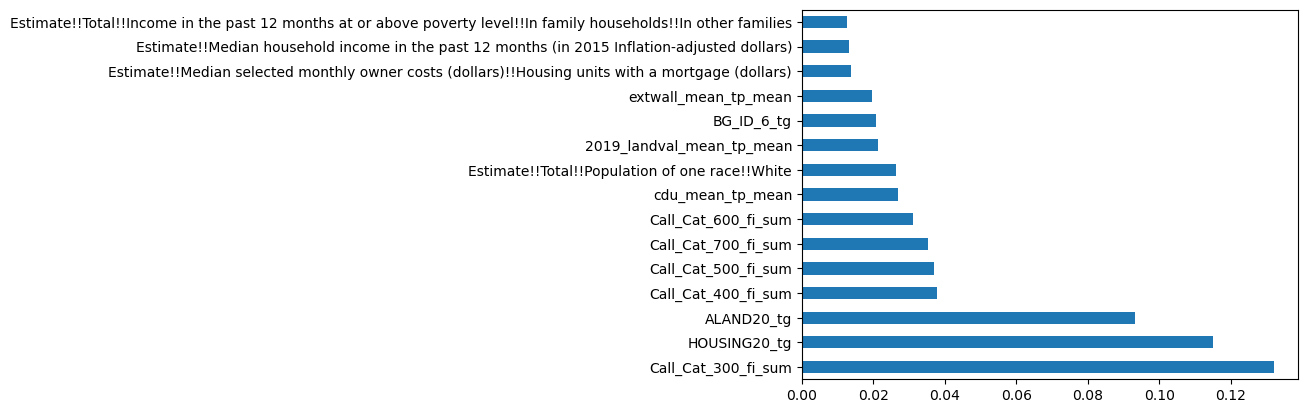

In [85]:
### Select top 10 predictors:
random.seed(1299)

feature_imp = pd.Series(rfcsf.feature_importances_, index = feature_list).sort_values(ascending = False)
feature_imp_sel = feature_imp.iloc[0:15] #33
feature_imp_sel_s = feature_imp_sel.sort_values(ascending = False)
feature_plot_1 = feature_imp_sel_s.plot.barh()  

In [86]:
#feature_imp #300, 600, 400, 700, 500, 800, 100

In [87]:
#For viz in Tableau
random.seed(1299)
#feature_imp_sel_df = pd.DataFrame(feature_imp_sel)
#feature_imp_sel_df.to_csv('feature_imp_sel_sum.csv',index=True, na_rep='NA' )
confusion_matrix(y_test, y_pred)  

array([[445,  76],
       [126, 201]])

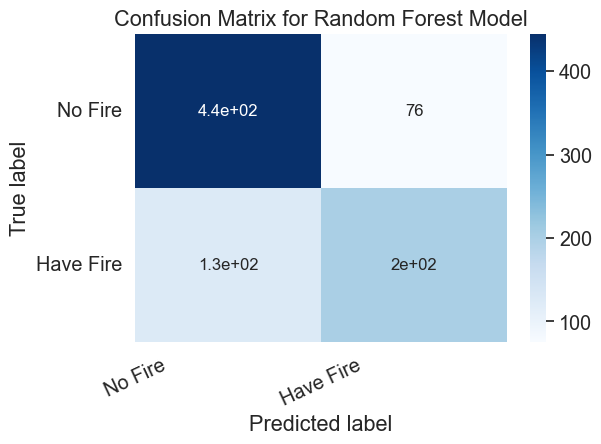

In [88]:
# Get and reshape confusion matrix data
random.seed(1299)
matrix = confusion_matrix(y_test, y_pred)
# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1.3)
sns.heatmap(matrix, annot=True, annot_kws={'size':12},
            cmap=plt.cm.Blues)
# Add labels to the plot
class_names = ['No Fire','Have Fire']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [89]:
random.seed(1299)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
#.828, .84, .835, .839, .79, .95, 96, .94  .95  .76, .77
#.78, .73

ACCURACY OF THE MODEL:  0.7617924528301887


# Probability Calibration curves: examining confidence on the prediction

### "When performing classification one often wants to predict not only the class label, but also the associated probability. This probability gives some kind of confidence on the prediction. This example demonstrates how to visualize how well calibrated the predicted probabilities are using calibration curves, also known as reliability diagrams. Calibration of an uncalibrated classifier will also be demonstrated." 


In [90]:
# Select 4 methods here
#from sklearn.ensemble import GradientBoostingClassifier
random.seed(1299) 
#gb_model.fit(X_train, y_train)
#gnb = GaussianNB()
###svc = NaivelyCalibratedLinearSVC(C=1.0, dual="auto")
rfcsf = RandomForestClassifier(bootstrap=False,max_depth=11,max_features=6,min_samples_leaf=3,min_samples_split=5,n_estimators=42)   
abc = AdaBoostClassifier(algorithm='SAMME',base_estimator=dtclf,learning_rate = 0.2,n_estimators=4, random_state=42)
rfcsf_isotonic = CalibratedClassifierCV(rfcsf, cv=2, method="isotonic")
rfcsf_sigmoid = CalibratedClassifierCV(rfcsf, cv=2, method="sigmoid")
gbc = GradientBoostingClassifier()  #BG_9
lr = LogisticRegression(C=1.0)
#lr = LogisticRegression()

clf_list = [#(gbc, "Gradient Boosting"),
            #(lr, "Logistic Regression"), 
            (rfcsf, "Random Forest"),  
            #(svc, "SVC")
            (rfcsf_isotonic, "Random Fores + Isotonic"),
            (rfcsf_sigmoid, "Random Fores + Sigmoid"),   #CalibratedClassifierCV(rfcsf, cv=2, method="sigmoid")
            (abc,'AdaBoostClassifier')
]

In [91]:
#Source: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
def calibration_plots_processor (clf_list,title):
    random.seed(1299)  #.18  #.52, .53  #.49, .43
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}
    for i, (clf, name) in enumerate(clf_list):
        clf.fit(X_train, y_train)
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title(title)

    # Add histogram
    grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
    for i, (_, name) in enumerate(clf_list):
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

    plt.tight_layout()
    return plt.show()

def calibration_report (clf_list,title):
    scores = defaultdict(list)
    for i, (clf, name) in enumerate(clf_list):
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        y_pred = clf.predict(X_test)
        scores[title].append(name)

        for metric in [brier_score_loss, log_loss, roc_auc_score]:
            score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[score_name].append(metric(y_test, y_prob[:, 1]))

        for metric in [precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score]:
            score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[score_name].append(metric(y_test, y_pred))

        score_df = pd.DataFrame(scores).set_index(title)
        score_df.round(decimals=3)
    score_df_mf = score_df.copy()
    return score_df_mf
#Random Fores + Sigmoid	

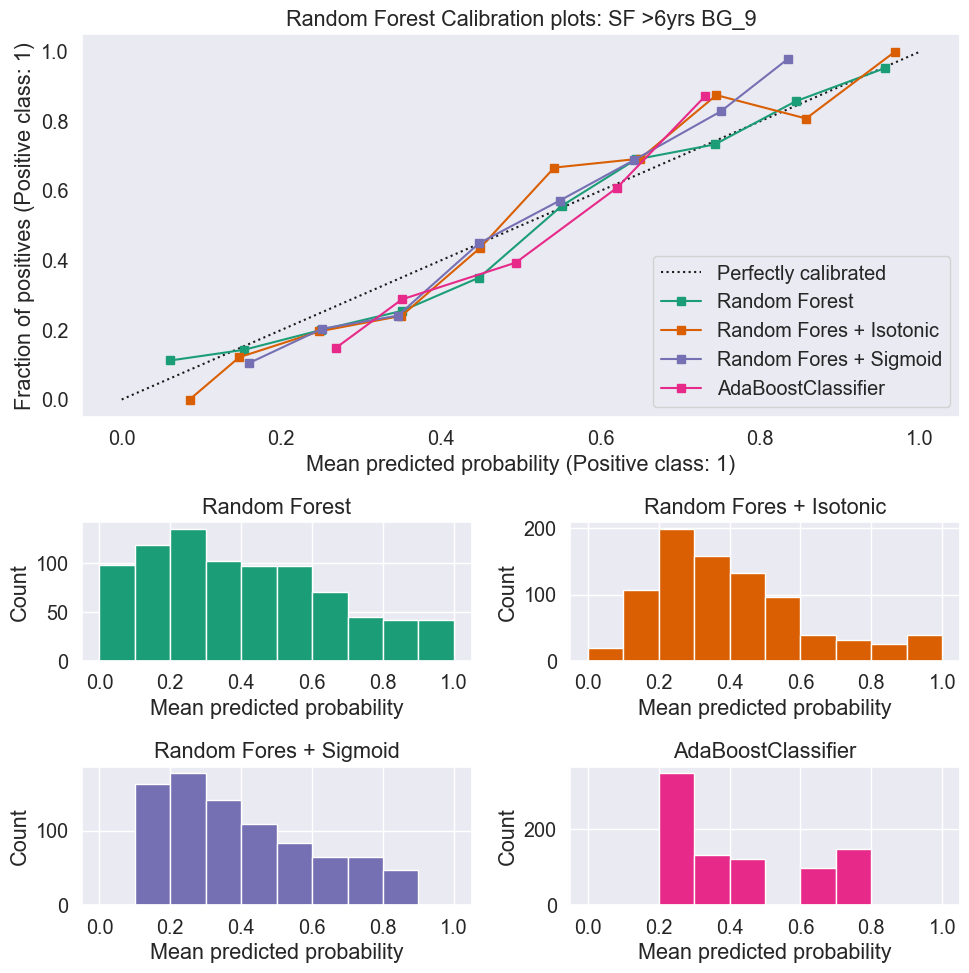

Elapsed 3799988.0 µs


In [92]:
start = datetime.now()
calibration_plots_sf = calibration_plots_processor (clf_list,"Random Forest Calibration plots: SF >6yrs BG_9")
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")
calibration_plots_sf


In [93]:
start = datetime.now()
score_df_sf = calibration_report (clf_list,"Classifier SF >6yrs BG_9")
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")
score_df_sf
#Best: Gradient Boostin & Random Fores + Sigmoid	
# compare calibration scores Brier loss, Log loss
#o w/ RF
# Random Fores + Sigmoid

Elapsed 1930643.0 µs


,Brier loss,Log loss,Roc auc,Precision,Recall,F1,Accuracy,Cohen kappa
Classifier SF >6yrs BG_9,,,,,,,,
Random Forest,0.17,0.52,0.80,0.70,0.64,0.66,0.75,0.47
Random Fores + Isotonic,0.17,0.52,0.81,0.76,0.55,0.64,0.76,0.46
Random Fores + Sigmoid,0.17,0.52,0.80,0.72,0.57,0.64,0.75,0.45
AdaBoostClassifier,0.18,0.54,0.80,0.77,0.58,0.66,0.77,0.49


In [94]:
#cen
#Random Fores + Sigmoid
       # Accuracy	Balanced ROC   AUC	F1 Score
#Model					
#LinearSVC	0.75	0.73	0.73	0.75	0.78

                        Brier 	Log 	Roc 	Prec	Recall	F1	Accuracy	Cohen kappa
Classifier SF >6yrs BG_9								
        Random Forest	0.17	0.52	0.80	0.68	0.64	0.66	0.75	0.46
Random Fores + Isotonic	0.17	0.52	0.81	0.64	0.67	0.66	0.73	0.43
Random Fores + Sigmoid	0.17	0.52	0.81	0.66	0.66	0.66	0.74	0.45
    AdaBoostClassifier	0.19	0.56	0.78	0.68	0.65	0.67	0.75	0.46


Brier loss	Log loss	Roc auc	Precision	Recall	F1	Accuracy	Cohen kappa
Classifier SF >6yrs BG_9								
Gradient Boosting	0.18	0.52	0.80	0.69	0.65	0.67	0.75	0.47
Random Forest	0.18	0.55	0.78	0.65	0.61	0.63	0.72	0.40
Random Fores + Sigmoid	0.18	0.53	0.80	0.66	0.66	0.66	0.74	0.44
AdaBoostClassifier	0.20	0.58	0.80	0.66	0.65	0.65	0.73	


                        Brier	Log   Roc/auc Precision	Recall	F1	  Accuracy	Cohen
Classifier SF >6yrs								
    Gradient Boosting	0.17	0.52	0.80	0.68	0.61	0.64	0.74	0.44
    Logistic Regression	0.20	0.60	0.74	0.67	0.46	0.55	0.71	0.34
Random Fores + Isotonic	0.17	0.51	0.81	0.64	0.66	0.65	0.73	0.43
    AdaBoostClassifier	0.23	0.65	0.78	0.63	0.65	0.64	0.72	0.41



# SF Summary Analysis, >6 yr (1/1/2016-6/30/2022)

    Random Fores + Isotonic: Best

    Probability scores:  brier loss, log loss, & ROC AUC.  
    Prediction scores:   
            For "Fire" (1) only: precision, recall, f1 
            For the model: accuracy, cohen_kappa 
    
    A lower score is better for both Brier loss and log loss: a perfect score would be "0".
    A random model's score for Brier loss: ~ 0.25; log loss: ~ 0.693.  >Gradient Boostin: Brier:0.18 Log:0.52		
    Higher results are better for all other scores.

    Scores for "Fire" (0,1) are listed both individually and as combined averages, below.



In [95]:
crsf = classification_report(y_test, y_pred) #) #model 2, .96, .95, .96
print(crsf)  #RF

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       521
           1       0.73      0.61      0.67       327

    accuracy                           0.76       848
   macro avg       0.75      0.73      0.74       848
weighted avg       0.76      0.76      0.76       848



In [96]:
#rfcsf_isotonic = CalibratedClassifierCV(rfcsf, cv=2, method="isotonic")
#rfcsf_sigmoid =
#gbc = GradientBoostingClassifier()  #BG_9

rfcsf.fit(X_train, y_train)  
#y_pred = gbcsf.predict(X_test)
#gbc.fit(X_train, y_train)  
y_pred = rfcsf.predict(X_test)
crsf_rfcsf= classification_report(y_test, y_pred) #) #model 2, .96, .95, .96
print(crsf_rfcsf)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       521
           1       0.71      0.64      0.67       327

    accuracy                           0.76       848
   macro avg       0.75      0.74      0.74       848
weighted avg       0.76      0.76      0.76       848



In [97]:
rfcsf_sigmoid.fit(X_train, y_train)  
y_pred = rfcsf_sigmoid.predict(X_test)
crsf_rfcsf_sigmoid = classification_report(y_test, y_pred) #) #model 2, .96, .95, .96
print(crsf_rfcsf_sigmoid)

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       521
           1       0.77      0.58      0.66       327

    accuracy                           0.77       848
   macro avg       0.77      0.73      0.74       848
weighted avg       0.77      0.77      0.76       848



In [98]:
abc = AdaBoostClassifier(algorithm='SAMME',base_estimator=dtclf,learning_rate = 0.2,n_estimators=4, random_state=42)
abc.fit(X_train, y_train)  
y_pred = abc.predict(X_test)
crsf_abc = classification_report(y_test, y_pred) #) #model 2, .96, .95, .96
print(crsf_abc)

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       521
           1       0.77      0.58      0.66       327

    accuracy                           0.77       848
   macro avg       0.77      0.73      0.74       848
weighted avg       0.77      0.77      0.76       848



In [99]:
rfcsf_isotonic.fit(X_train, y_train)  
y_pred = rfcsf_isotonic.predict(X_test)
crsf_rfcsf_isotonic = classification_report(y_test, y_pred) #) #model 2, .96, .95, .96
print(crsf_rfcsf_isotonic)

              precision    recall  f1-score   support

           0       0.76      0.90      0.82       521
           1       0.77      0.54      0.63       327

    accuracy                           0.76       848
   macro avg       0.76      0.72      0.73       848
weighted avg       0.76      0.76      0.75       848



In [100]:
gbc = GradientBoostingClassifier()  #BG_9
gbc.fit(X_train, y_train)  
y_pred = gbc.predict(X_test)
crsf_gbc = classification_report(y_test, y_pred) #) #model 2, .96, .95, .96
print(crsf_gbc)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       521
           1       0.71      0.64      0.67       327

    accuracy                           0.76       848
   macro avg       0.75      0.74      0.74       848
weighted avg       0.76      0.76      0.76       848



### rfcsf = RandomForestClassifier(bootstrap=False,max_depth=32,max_features=46,min_samples_leaf=5,min_samples_split=5,n_estimators=64)   

         precision    recall  f1-score   support

           0       0.76      0.80      0.78       521
           1       0.65      0.61      0.63       327

    accuracy                           0.73       848
   macro avg       0.71      0.70      0.71       848
weighted avg       0.72      0.73      0.72       848




# Fire Risk Prediction Tables:  SF

In [101]:
joined_df = joined_df_sf.copy()

In [102]:
joined_df.shape, tiger.shape 

((3392, 60), (4923, 9))

In [103]:
joined_df.head(2)

,"Estimate!!Total!!Owner-occupied housing units!!1, detached",Estimate!!Median selected monthly owner costs (dollars)!!Housing units with a mortgage (dollars),Estimate!!Median selected monthly owner costs (dollars)!!Housing units without a mortgage (dollars),Estimate!!Total!!Population of one race,Estimate!!Total!!Population of one race!!White,Estimate!!Total!!Population of one race!!Asian alone,"Estimate!!Total!!Population of two or more races!!Two races excluding Some other race, and three or more races",Estimate!!Total!!Income in the past 12 months at or above poverty level!!Married-couple family,Estimate!!Total!!Income in the past 12 months at or above poverty level!!Married-couple family!!With related children of the householder under 18 years!!Under 5 years only,"Estimate!!Total!!Income in the past 12 months at or above poverty level!!Other family!!Female householder, no husband present!!No related children of the householder under 18 years",Estimate!!Total!!Income in the past 12 months at or above poverty level!!Family households!!Married-couple family!!Householder 25 to 44 years,"Estimate!!Total!!Income in the past 12 months at or above poverty level!!Family households!!Other family!!Female householder, no husband present!!Householder 25 to 44 years",Estimate!!Total!!Income in the past 12 months below poverty level!!In family households!!In married couple families!!All relatives,"Estimate!!Total!!Income in the past 12 months below poverty level!!In family households!!In other families!!Female householder, no husband present!!All relatives",Estimate!!Total!!Income in the past 12 months at or above poverty level!!In family households!!In other families,Estimate!!Total!!Income in the past 12 months at or above poverty level!!In non-family households and other living arrangement,Estimate!!Total!!Income in the past 12 months at or above poverty level!!In non-family households and other living arrangement!!Other living arrangement,Estimate!!Total!!Income in the past 12 months below poverty level!!No disability!!In labor force!!Civilian!!Employed,Estimate!!Total!!Income in the past 12 months at or above poverty level!!With a disability,Estimate!!Total!!Income in the past 12 months at or above poverty level!!No disability!!Not in labor force,Estimate!!Total!!18 to 64 years!!Nonveteran!!Income in the past 12 months below poverty level!!With a disability,Estimate!!Total!!18 to 34 years!!With one type of health insurance coverage,Estimate!!Total!!18 to 34 years!!No health insurance coverage,Estimate!!Total!!35 to 64 years!!With one type of health insurance coverage!!With direct-purchase health insurance only,Estimate!!Total!!35 to 64 years!!With two or more types of health insurance coverage!!Other coverage combinations,Estimate!!Total!!65 years and over!!With one type of health insurance coverage,Estimate!!Total!!Education,Estimate!!Total!!6 rooms,Estimate!!Total!!7 rooms,Estimate!!Total!!9 or more rooms,Estimate!!Total!!Renter occupied!!4 rooms,Estimate!!Total!!3 bedrooms,Estimate!!Total!!3 or more bedrooms,Estimate!!Total!!Different house in United States 1 year ago!!Same Micropolitan Statistical Area!!Moved from principal city,"Estimate!!Total!!With interest, dividends, or net rental income","Estimate!!Total!!No interest, dividends, or net rental income",Estimate!!Total!!Under 6 years!!Living with two parents,Estimate!!Total!!6 to 17 years!!Living with one parent,Estimate!!Total!!Renter occupied!!Built 2000 to 2009,Estimate!!Total!!Renter occupied!!1 or more vehicles available,Estimate!!Median gross rent,Estimate!!Total!!Different house,Estimate!!Total!!Owner occupied!!Built 2000 to 2009,Estimate!!Total!!Owner occupied!!Built 1990 to 1999,Estimate!!Total!!Owner occupied!!Moved in 1990 to 1999,Estimate!!Median household income in the past 12 months (in 2015 Inflation-adjusted dollars),Estimate!!Median household income in the past 12 months (in 2015 Inflation-adjusted dollars)!!Householder 25 to 44 years,Estimate!!Median select

In [104]:
#tiger_2_sel = tiger_2.loc[:, ('BG_ID_6_tg', 'Station_tg', 'Battalion_tg', 'geometry_stion_tg', 'geometry_bt_tg')]
#tiger_2_sel.info()

In [105]:
#joined_df_sf  joined_df = joined_df_sf.copy()

#pred_mf_adr = fire_risk_tables_processor_mf (joined_df_sf, tiger_2)
#pred_mf_adr.head()

In [106]:
# function to classify risk based on probability
# w/ rfcsf
def fire_risk(prob):
  return np.where(prob<1/3,'Low Risk',
            np.where(prob<2/3, 'Moderate Risk',
              np.where(prob<=1, 'High Risk', np.nan)))


def fire_risk_tables_processor_sf (joined_df):  
        joined_df.reset_index(inplace=True)  #sf
        #predprob =rfcsf_sigmoid.predict_proba(joined_df.drop(['BG_ID_9_tg','FireIndicator'], axis = 1))
        predprob =rfcsf.predict_proba(joined_df.drop(['BG_ID_9_tg','FireIndicator'], axis = 1))
        pd.DataFrame(predprob).shape
        result_data = pd.concat([joined_df[['BG_ID_9_tg']].reset_index(drop=True),
                                 pd.DataFrame(predprob[:,1],columns=['Predicted Fire Probability_9']).reset_index(drop=True)],
                                 axis=1)
        
        joined_df_raw_sf.reset_index(inplace = True)

        data = {'BG_ID_6':joined_df_raw_sf.BG_ID_6_tg,
            'BG_ID_9':result_data.BG_ID_9_tg,
            'Predicted_Fire_Probability_9':predprob[:,1], 
            'Predicted_Fire_Risk_9': fire_risk(predprob[:,1]),
            'geometry_6':joined_df_raw_sf.geometry_6_tg,
            'geometry_9':joined_df_raw_sf.geometry_9_tg,
            'HOUSING20_9': joined_df_raw_sf.HOUSING20_tg,
            'POP20_9': joined_df_raw_sf.POP20_tg,
            'ALAND20_9': joined_df_raw_sf.ALAND20_tg,
           
            } 
        pred_sf=pd.DataFrame(data=data) #sf
        pred_sf.sort_values(['BG_ID_9'],ascending=True, inplace = True)
        pred_sf.reset_index(drop=True, inplace=True)
        # groupby BG_ID_6 -> mean
        df = pred_sf.loc[:, ('BG_ID_6','Predicted_Fire_Probability_9')]
        df_mean = df.groupby("BG_ID_6").mean()
        df_mean.columns = df_mean.columns.str.replace(r"9", "6")
        # groupby BG_ID_6 -> sum
        df2 = pred_sf.loc[:, ('BG_ID_6','HOUSING20_9', 'POP20_9', 'ALAND20_9')]
        df2_sum = df2.groupby("BG_ID_6").sum()
        df2_sum.columns = df2_sum.columns.str.replace(r"9", "6")
        df_mean_sum =pd.concat([df_mean, df2_sum], axis=1)
        #df_mean_sum.reset_index(inplace=True)  #? in mf
        pred_sf_2 = pd.merge(pred_sf,df_mean_sum,left_on = ['BG_ID_6'],right_on = ['BG_ID_6'],how= 'left') 
        predprob_2 = pred_sf_2['Predicted_Fire_Probability_6'].to_numpy()
        
        data = {'BG_ID_6':pred_sf_2.BG_ID_6,
                'BG_ID_9':pred_sf_2.BG_ID_9, 
                'Predicted_Fire_Probability_6_sf':predprob_2,
                'Predicted_Fire_Probability_9_sf':pred_sf_2.Predicted_Fire_Probability_9, 
                'Predicted_Fire_Risk_6_sf': fire_risk(predprob_2),
                'Predicted_Fire_Risk_9_sf':pred_sf_2.Predicted_Fire_Risk_9,
                'geometry_6':pred_sf_2.geometry_6, 
                'geometry_9':pred_sf_2.geometry_9, 
                'HOUSING20_6':pred_sf_2.HOUSING20_6, 
                'HOUSING20_9':pred_sf_2.HOUSING20_9, 
                'POP20_6':pred_sf_2.POP20_6, 
                'POP20_9':pred_sf_2.POP20_9,
                'ALAND20_6':pred_sf_2.ALAND20_6, 
                'ALAND20_9':pred_sf_2.ALAND20_9,
                    } 
        pred_sf_96=pd.DataFrame(data=data)
        pred_sf_96.sort_values(['BG_ID_9', 'Predicted_Fire_Probability_9_sf'],ascending=[True, False], inplace = True)
        pred_sf_96['BG_ID_6'] = pred_sf_96['BG_ID_6'].astype(str)  #.str.replace(r'\D', '', regex=True)

        tiger_2_sel = tiger_2.loc[:, ('BG_ID_6_tg', 'Station_tg', 'Battalion_tg')]  #'geometry_stion_tg
        tiger_2_sel.drop_duplicates(inplace = True)
        pred_sf_stion = pd.merge(tiger_2_sel, pred_sf_96, left_on = ['BG_ID_6_tg'],right_on = ['BG_ID_6'],how= 'right') 
        return pred_sf_stion

        

In [107]:
#tiger_2.info()

In [108]:
#joined_df = joined_df_sf.copy()

pred_sf_stion = fire_risk_tables_processor_sf (joined_df)  #train_sel_sf train_sel_sf

#pred_sf_stion = fire_risk_tables_processor_sf (joined_df)  #train_sel_sf

pred_sf_stion.head(2)
#pred_mf_stion_a_geodf= gpd.GeoDataFrame(pred_mf_stion_a,geometry= pred_mf_stion_a.geometry_6)  #, geometry=gpd.points_from_xy(fire_3.Longitude_fi, fire_3.Latitude_fi))


,BG_ID_6_tg,Station_tg,Battalion_tg,BG_ID_6,BG_ID_9,Predicted_Fire_Probability_6_sf,Predicted_Fire_Probability_9_sf,Predicted_Fire_Risk_6_sf,Predicted_Fire_Risk_9_sf,geometry_6,geometry_9,HOUSING20_6,HOUSING20_9,POP20_6,POP20_9,ALAND20_6,ALAND20_9
0,211011,2,1,211011,211011004,0.11,0.66,Low Risk,Moderate Risk,"POLYGON ((-84.344581 33.881133, -84.34545 33.8...","POLYGON ((-84.343395 33.885765, -84.343285 33....",402,78,1159,207,623203,71169
1,211011,2,1,211011,211011005,0.11,0.07,Low Risk,Low Risk,"POLYGON ((-84.344581 33.881133, -84.34545 33.8...","POLYGON ((-84.343968 33.883686, -84.34337 33.8...",402,26,1159,78,623203,17963


In [109]:
pred_sf_stion.BG_ID_6.nunique(), pred_sf_stion.BG_ID_9.nunique(), 

(454, 3392)

In [110]:
#pred_sf_stion.to_csv('pred_sf_stion.csv',index=True, na_rep='NA' )


In [111]:
#pred_sf_stion.info()

In [112]:
#unique(pred_sf_stion)

In [113]:
check_missing_values(pred_sf_stion)

'No missing values'

In [114]:
pred_sf_stion['Predicted_Fire_Risk_9_sf'].value_counts()
#Low Risk         2838
#High Risk        1351
#Moderate Risk     736



#High Risk: 987, Moderate Risk: 1254, Low Risk: 1997

Low Risk         2354
Moderate Risk     947
High Risk         937
Name: Predicted_Fire_Risk_9_sf, dtype: int64

In [115]:
#pred_sf_3.drop_duplicates(subset='')
cols = [col for col in pred_sf_stion.columns if '_9' in col]
pred_sf_6 = pred_sf_stion.drop(cols,axis=1)
pred_sf_6.drop_duplicates(inplace = True)
pred_sf_6.shape  #(511, 7)

(561, 10)

In [116]:
pred_sf_6.head(2)

,BG_ID_6_tg,Station_tg,Battalion_tg,BG_ID_6,Predicted_Fire_Probability_6_sf,Predicted_Fire_Risk_6_sf,geometry_6,HOUSING20_6,POP20_6,ALAND20_6
0,211011,2,1,211011,0.11,Low Risk,"POLYGON ((-84.344581 33.881133, -84.34545 33.8...",402,1159,623203
13,211012,15,2,211012,0.45,Moderate Risk,"POLYGON ((-84.339227 33.89031, -84.339326 33.8...",212,623,513391


In [117]:
pred_sf_6['Predicted_Fire_Risk_6_sf'].value_counts()
#Moderate Risk    306
#Low Risk         179
#High Risk         88

#Moderate Risk    306 vs. Ac #Moderate Risk     40
#Low Risk         173        #Low Risk         102
#High Risk         64        #High Risk         43
#above

#High Risk: 76, Moderate Risk: 306, Low Risk: 179

Moderate Risk    287
Low Risk         208
High Risk         66
Name: Predicted_Fire_Risk_6_sf, dtype: int64

In [118]:
#pred_sf_6.BG_ID_6.nunique(), pred_ash_geoid.BG_ID.nunique()  

In [119]:
unique(pred_sf_6)  #BG_ID_6 511

,Distinct
BG_ID_6_tg,454
BG_ID_6,454
Predicted_Fire_Probability_6_sf,454
geometry_6,454
ALAND20_6,454
POP20_6,395
HOUSING20_6,356
Station_tg,26
Battalion_tg,5
Predicted_Fire_Risk_6_sf,3


In [120]:
#Low Risk         102
#High Risk         43
#Moderate Risk     40
#pred_ash_geoid.BG_ID.nunique()  #185  #clf.predict_proba

In [121]:
#unique(pred_ash_geoid)